Test the `src` package.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os, os.path
import sys
import json
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import torch
import trimesh

sys.path.insert(0, "../")
import src
from src import workspace as ws

# Initialization

In [3]:
from src.utils import set_seed

seed = 0
expdir = "../experiments/src_test/"
set_seed(seed)
ws.build_experiment_dir(expdir)
specs = ws.load_specs(expdir)

print(f"Running experiment in {expdir}")
print(f"Seeds initialized to {seed}.")

Running experiment in ../experiments/src_test/
Seeds initialized to 0.


# Data

In [4]:
from src.data import SdfDataset
from torch.utils.data import DataLoader

batch_size = 8
n_samples = 8192

with open(specs["TrainSplit"]) as f:
    instances = json.load(f)

dataset = SdfDataset(specs["DataSource"], instances, n_samples, 
                     specs["SamplesDir"], specs["SamplesFile"])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
len_dataset = len(dataset)

print(f"{len_dataset} shapes in training dataset.")

100 shapes in training dataset.


8192 points for /scratch/cvlab/datasets/datasets_talabot/shapenet_disn/1_normalized/cars/samples/100715345ee54d7ae38b52b4ee9d36a3/deepsdf.npz shape.


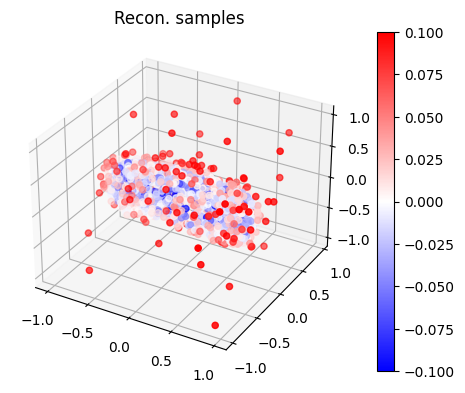

In [5]:
# Visualize
from matplotlib import cm

idx = 0
filename = dataset.filenames[idx]
idx, points, sdf = dataset[0]
print(f"{len(points)} points for {filename} shape.")

N = 1000
_indices = np.random.permutation(len(points))[:N]
points, sdf = points[_indices], sdf[_indices]
cmap = colormaps['bwr']
c = np.clip(sdf[:,0], -0.1, 0.1)
vmax = np.abs(c).max()
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(points[:,0], points[:,1], points[:,2], c=c, cmap=cmap, vmin=-vmax, vmax=vmax)
fig.colorbar(p)
ax.set_title("Recon. samples")
fig.tight_layout()

# Model and latents

In [6]:
from src.model import get_model, get_latents, features

latent_dim = specs["LatentDim"]
model = get_model(
    specs["Network"],
    **specs["NetworkSpecs"]
).cuda()

latents = get_latents(len(dataset), latent_dim, None)

print(f"Model has {sum([x.nelement() for x in model.parameters()]):,} parameters.")
print(f"{latents.num_embeddings} latent vectors of size {latents.embedding_dim}.")

# Initialize history
history = {'epoch': 0}

Model has 2,503,427 parameters.
100 latent vectors of size 256.


# Training

In [7]:
from src.loss import get_loss_recon
from src.optimizer import get_optimizer, get_scheduler
from src.utils import clamp_sdf

n_epochs = 20
clampD = specs["ClampingDistance"]

# Loss and optimizer
loss_recon = get_loss_recon("L1-Hard", reduction='none')
latent_reg = specs["LatentRegLambda"]

optimizer = get_optimizer([model, latents], type="adam", lrs=[0.0005, 0.001])
scheduler = get_scheduler(optimizer, Type="Constant")

# Training
for key in ['loss', 'loss_reg', 'lr', 'lr_lat', 'lat_norm']:
    if key not in history:
        history[key] = []
model.train()
for epoch in range(history['epoch']+1, n_epochs+1):
    time_epoch = time.time()
    running_losses = {'loss': 0., 'loss_reg': 0.}
    optimizer.zero_grad()

    for i, (indices, xyz, sdf_gt) in enumerate(dataloader):
        xyz = xyz.cuda()  # BxNx3
        sdf_gt = sdf_gt.cuda()  # BxNx1
        indices = indices.cuda().unsqueeze(-1)  # Bx1
        batch_latents = latents(indices)  # Bx1xL

        sdf_pred = model(batch_latents, xyz)
        if clampD is not None and clampD > 0.:
            sdf_pred = clamp_sdf(sdf_pred, clampD, ref=sdf_gt)
            sdf_gt = clamp_sdf(sdf_gt, clampD)

        loss = loss_recon(sdf_pred, sdf_gt).mean()
        running_losses['loss'] += loss.item() * batch_size
        # Latent regularization
        if latent_reg is not None and latent_reg > 0.:
            loss_reg = min(1, epoch / 100) * batch_latents[:,0,:].square().sum()
            loss = loss + latent_reg * loss_reg
            running_losses['loss_reg'] += loss_reg.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

    history['epoch'] += 1
    history['loss'].append(running_losses['loss'] / len_dataset)
    history['loss_reg'].append(running_losses['loss_reg'] / len_dataset)
    history["lr"].append(optimizer.state_dict()["param_groups"][0]["lr"])
    history["lr_lat"].append(optimizer.state_dict()["param_groups"][1]["lr"])
    lat_norms = torch.norm(latents.weight.data.detach(), dim=1).cpu()
    history["lat_norm"].append(lat_norms.mean())

    # Apply lr-schedule
    if scheduler is not None:
        scheduler.step()
    
    print(f"Epoch {epoch}/{n_epochs}: loss={loss.item():.6f} - loss_reg={loss_reg.item():.6f}" + \
          f" ({time.time() - time_epoch:.0f}s/epoch)")
torch.cuda.empty_cache()

Epoch 1/20: loss=0.070344 - loss_reg=0.038850 (1s/epoch)
Epoch 2/20: loss=0.054175 - loss_reg=0.081363 (1s/epoch)
Epoch 3/20: loss=0.050322 - loss_reg=0.126259 (1s/epoch)
Epoch 4/20: loss=0.054757 - loss_reg=0.159668 (1s/epoch)
Epoch 5/20: loss=0.050781 - loss_reg=0.205940 (1s/epoch)
Epoch 6/20: loss=0.054032 - loss_reg=0.246588 (1s/epoch)
Epoch 7/20: loss=0.050377 - loss_reg=0.266969 (1s/epoch)
Epoch 8/20: loss=0.055112 - loss_reg=0.322690 (1s/epoch)
Epoch 9/20: loss=0.041950 - loss_reg=0.333022 (1s/epoch)
Epoch 10/20: loss=0.043263 - loss_reg=0.385385 (1s/epoch)
Epoch 11/20: loss=0.034212 - loss_reg=0.403235 (1s/epoch)
Epoch 12/20: loss=0.028348 - loss_reg=0.442545 (1s/epoch)
Epoch 13/20: loss=0.043413 - loss_reg=0.522879 (1s/epoch)
Epoch 14/20: loss=0.025260 - loss_reg=0.522683 (1s/epoch)
Epoch 15/20: loss=0.031270 - loss_reg=0.574303 (1s/epoch)
Epoch 16/20: loss=0.032836 - loss_reg=0.595988 (1s/epoch)
Epoch 17/20: loss=0.036213 - loss_reg=0.626334 (1s/epoch)
Epoch 18/20: loss=0.026

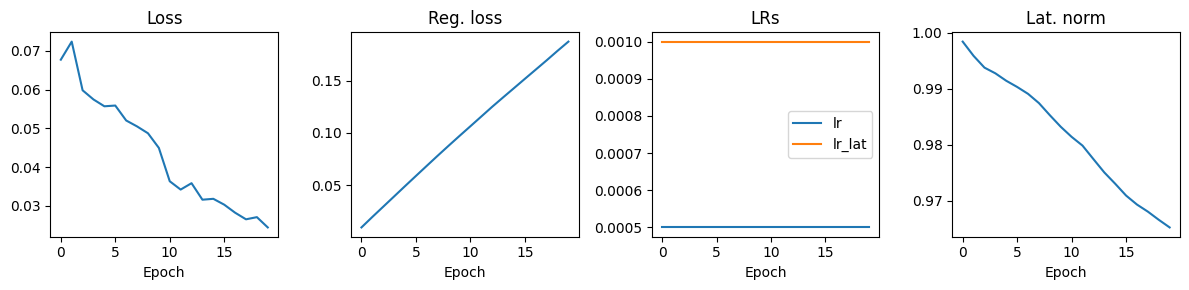

In [8]:
# Visualize training history
fig, axs = plt.subplots(1, 4, figsize=(12,3))
axs[0].plot(history['loss'])
axs[0].set_title("Loss")
axs[1].plot(history['loss_reg'])
axs[1].set_title("Reg. loss")
axs[2].plot(history['lr'])
axs[2].plot(history['lr_lat'])
axs[2].legend(['lr', 'lr_lat'])
axs[2].set_title("LRs")
axs[3].plot(history['lat_norm'])
axs[3].set_title("Lat. norm")
for ax in axs.flatten():
    ax.set_xlabel("Epoch")
fig.tight_layout();

In [9]:
from src import derivative as deriv

lat = latents(torch.tensor([0]).cuda())
xyz = torch.randn(10, 3).cuda()

model.eval()
out1 = deriv.get_laplacian(model, lat, xyz.requires_grad_())
out2 = deriv.get_laplacian_fd(model, lat, xyz.requires_grad_(), 1e-2)
out1 - out2

tensor([-0.9060, -0.1383, -1.7595, -4.9257,  0.9918,  1.4567, -0.0429,  0.2384,
        -0.2623,  3.1507], device='cuda:0', grad_fn=<SubBackward0>)

# Results

In [10]:
from sklearn.decomposition import PCA

from src.utils import sample_latents as _sample_latents

_pca = PCA(whiten=True).fit(latents.weight.detach().cpu().numpy())
def sample_latents(n=1, expvar=None):
    """PCA sampling of latent(s) from training distribution."""
    return _sample_latents(latents, n_samples=n, expvar=expvar, pca=_pca)

## Visualization

Clamping at 0.1.


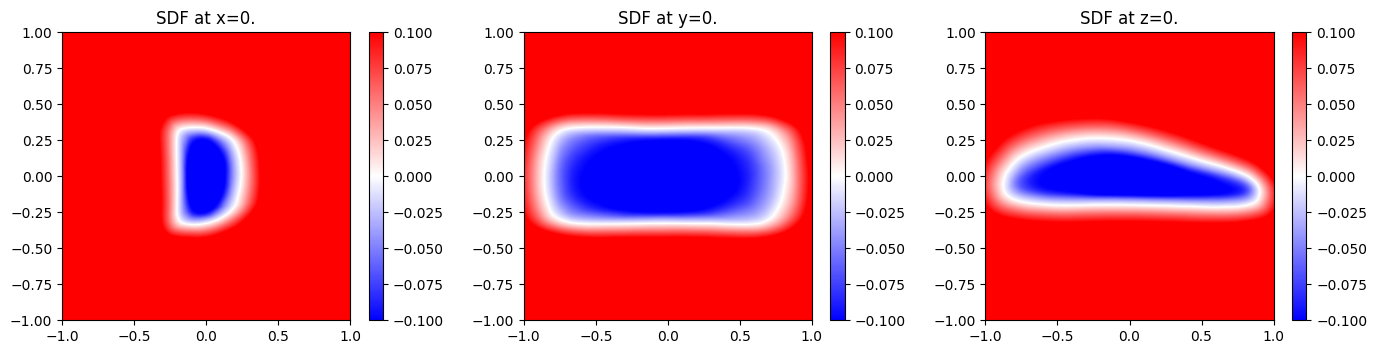

In [22]:
# SDF
from src import visualization as viz

idx = 0
clamp = True

clamp &= clampD is not None and clampD > 0.
latent = latents(torch.tensor([idx]).cuda()) if idx is not None else sample_latents()
print(f"Clamping at {clampD}." if clamp else "No clamping.")

viz.plot_sdf_slices(model, latent, clampD=clampD if clamp else None, cmap='bwr', contour=False).show()

In [12]:
# Mesh
from src.mesh import create_mesh

idx = 0
latent = latents(torch.tensor([idx]).cuda()) if idx is not None else sample_latents()
mesh = create_mesh(model, latent, 256, 32**3, verbose=True)
mesh.show()

sdf-prediction took 3.685s.


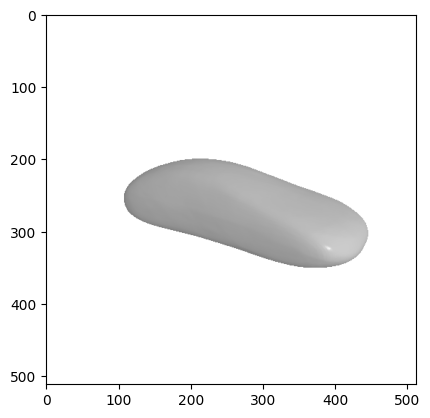

In [13]:
# Rendering
from src import visualization as viz

image = viz.render_mesh(mesh)
plt.imshow(image)

# Test

Reconstructing test shape 0 (11b09de6631b3b3ad997cda1a938a10d)


reconstruction took 2.624s.
Final error: 0.011532.
Latent: norm=1.3467 - std=0.0842
sdf-prediction took 0.387s.


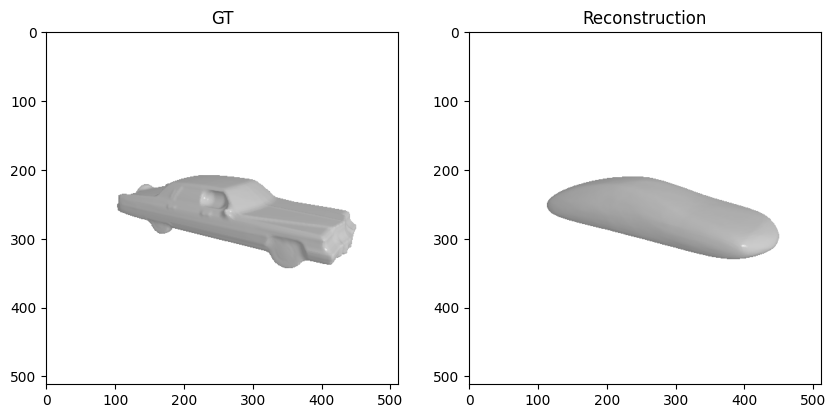

In [23]:
# Reconstruction
from src.reconstruct import reconstruct

idx = 0

with open(specs["TestSplit"]) as f:
    instances_t = json.load(f)
instance = instances_t[idx]
print(f"Reconstructing test shape {idx} ({instance})")

filename = os.path.join(specs["DataSource"], specs["SamplesDir"], instance, specs["SamplesFile"])
npz = np.load(filename)

err, latent = reconstruct(model, npz, 400, 8000, 5e-3, loss_recon, latent_reg, clampD, None, latent_dim, verbose=True)
print(f"Final error: {err:.6f}.")
print(f"Latent: norm={latent.norm():.4f} - std={latent.std():.4f}")
test_mesh = create_mesh(model, latent, 256, 32**3, grid_filler=True, verbose=True)

filename = os.path.join(specs["DataSource"], "meshes", instance+".obj")
gt_mesh = trimesh.load(filename)

images = viz.render_meshes([gt_mesh, test_mesh])
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(images[0]); axs[0].set_title("GT")
axs[1].imshow(images[1]); axs[1].set_title("Reconstruction")
fig.show()

In [25]:
# Metrics
from src.metric import chamfer_distance, mesh_iou

chamfer_samples = 30_000
iou_res = 256

gt_samples = gt_mesh.sample(chamfer_samples)
recon_samples = test_mesh.sample(chamfer_samples)
chamfer_val = chamfer_distance(gt_samples, recon_samples)
print(f"Chamfer-distance (x10^4) = {chamfer_val * 1e4:.6f}")

iou_val = mesh_iou(gt_mesh, test_mesh, iou_res)
print(f"IoU = {iou_val:.3f}")

Chamfer-distance (x10^4) = 7.556047
IoU = 0.869


In [16]:
raise RuntimeError("Stop here.")

RuntimeError: Stop here.

# Misc.